In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Forecasting using Prophet

### Installation

In [1]:
!pip install statsmodels --quiet
!pip install fbprophet --quiet

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet

In [3]:
cd ..

/kaggle


In [4]:
ls

input/  lib/  working/


### Data preparation

In [5]:
df = pd.read_csv('input/arsenal-data/prem-arsenal.csv')
df_1 = df.iloc[:38,:]
df_2 = df.iloc[38:2*(38),:]
df_3 = df.iloc[2*(38):3*(38):]
df.columns

Index(['date_col', 'home', 'away', 'score', 'points', 'home-adv', 'referee'], dtype='object')

In [6]:
df_1['cum_pts'] = df_1.points.cumsum()
df_2['cum_pts'] = df_2.points.cumsum()
df_3['cum_pts'] = df_3.points.cumsum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [7]:
df_table = pd.DataFrame()
df_table = df_table.append(df_1)
df_table = df_table.append(df_2)
df_table = df_table.append(df_3)
df_table = pd.get_dummies(df_table, columns=['referee'])

In [8]:
df_s = df_table.copy()
df_s['date_col'] = pd.to_datetime(df_s['date_col'])
df_s = df_s.set_index('date_col')
df_s.index = pd.date_range(start='15/08/2018', periods=df_s.shape[0], freq='W')
s=seasonal_decompose(df_s['cum_pts'])

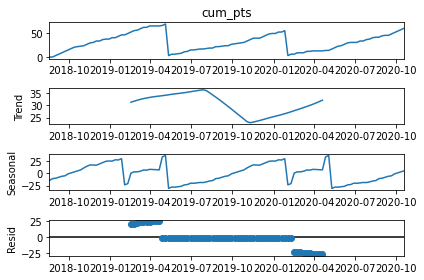

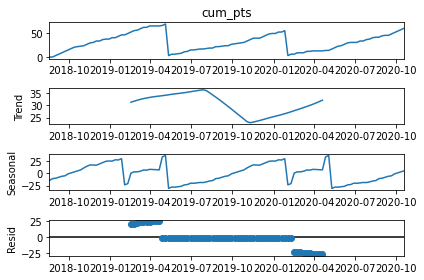

In [9]:
s.plot()

### Modelling

#### Without regressors

In [10]:
df_t = df_table[['date_col','cum_pts',]]
df_t.columns = ["ds", "y"]

<AxesSubplot:xlabel='date_col'>

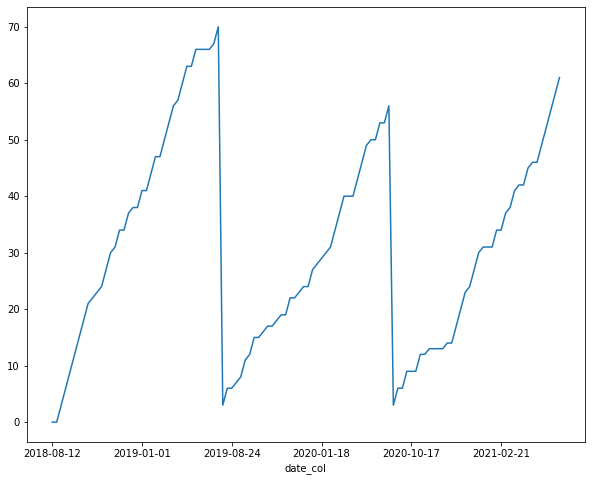

In [11]:
df_table.index = df_table['date_col']
df_table['cum_pts'].plot(figsize=(10, 8))

In [12]:
df_table.columns

Index(['date_col', 'home', 'away', 'score', 'points', 'home-adv', 'cum_pts',
       'referee_Andre Marriner', 'referee_Anthony Taylor',
       'referee_Chris Kavanagh', 'referee_Craig Pawson', 'referee_David Coote',
       'referee_Graham Scott', 'referee_Jonathan Moss', 'referee_Kevin Friend',
       'referee_Lee Mason', 'referee_Lee Probert', 'referee_Martin Atkinson',
       'referee_Michael Oliver', 'referee_Mike Dean', 'referee_Paul Tierney',
       'referee_Peter Bankes', 'referee_Stuart Attwell'],
      dtype='object')

In [13]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_t)

In [14]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=5, freq='W')


In [15]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

In [16]:
pred_df['cum_pts_preds'] = preds['yhat']
pred_df.head()

,ds,cum_pts_preds
0,2021-08-15,0
1,2021-08-22,0
2,2021-08-29,3
3,2021-09-05,6
4,2021-09-12,6


<AxesSubplot:xlabel='ds'>

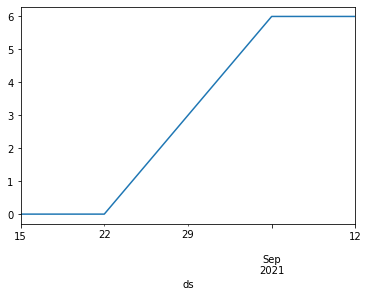

In [17]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()

#### with home-advantage

In [18]:
df_t = df_table[['date_col','cum_pts', 'home-adv']]
df_t.columns = ["ds", "y", "home-adv"]

<AxesSubplot:xlabel='date_col'>

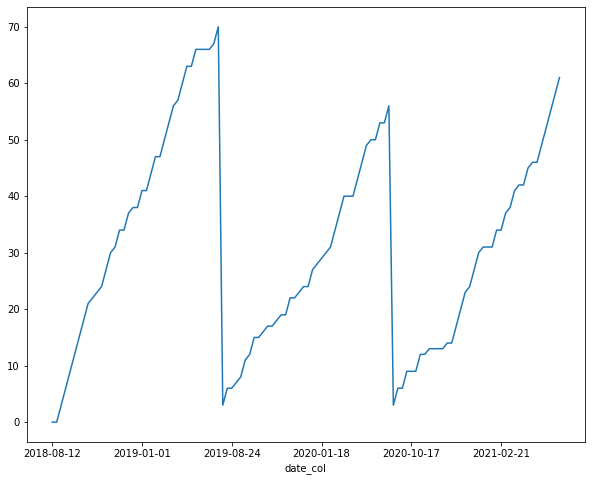

In [19]:
df_table.index = df_table['date_col']
df_table['cum_pts'].plot(figsize=(10, 8))

In [20]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('home-adv')
m.fit(df_t)

In [21]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=5, freq='W')
pred_df['home-adv'] = [0, 1, 0, 1, 1]

In [22]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

pred_df['cum_pts_preds'] = preds['yhat']
pred_df.head()

,ds,home-adv,cum_pts_preds
0,2021-08-15,0,0
1,2021-08-22,1,0
2,2021-08-29,0,3
3,2021-09-05,1,7
4,2021-09-12,1,7


<AxesSubplot:xlabel='ds'>

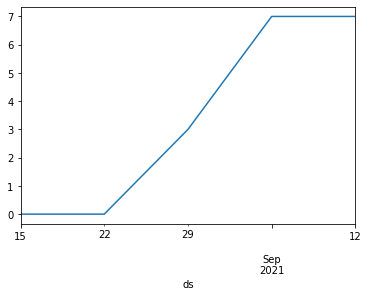

In [23]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()

#### with referees

In [24]:
df_table.columns

Index(['date_col', 'home', 'away', 'score', 'points', 'home-adv', 'cum_pts',
       'referee_Andre Marriner', 'referee_Anthony Taylor',
       'referee_Chris Kavanagh', 'referee_Craig Pawson', 'referee_David Coote',
       'referee_Graham Scott', 'referee_Jonathan Moss', 'referee_Kevin Friend',
       'referee_Lee Mason', 'referee_Lee Probert', 'referee_Martin Atkinson',
       'referee_Michael Oliver', 'referee_Mike Dean', 'referee_Paul Tierney',
       'referee_Peter Bankes', 'referee_Stuart Attwell'],
      dtype='object')

In [25]:
df_t = df_table[['date_col','cum_pts', 'home-adv', 'referee_Anthony Taylor',
                 'referee_Jonathan Moss', 'referee_Martin Atkinson',
                 'referee_Michael Oliver', 'referee_Mike Dean']]

df_t.columns = ["ds", "y", "home-adv",'referee_Anthony Taylor', 
                'referee_Jonathan Moss','referee_Martin Atkinson', 
                'referee_Michael Oliver','referee_Mike Dean']

In [26]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('home-adv')
m.add_regressor('referee_Anthony Taylor')
m.add_regressor('referee_Jonathan Moss')
m.add_regressor('referee_Martin Atkinson')
m.add_regressor('referee_Michael Oliver')
m.add_regressor('referee_Mike Dean')
m.fit(df_t)

In [27]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=5, freq='W')
pred_df['home-adv'] = [0, 1, 0, 1, 1]
pred_df['referee_Anthony Taylor'] = [0, 1, 0, 0, 1]
pred_df['referee_Jonathan Moss'] = [0, 0, 1, 0, 0]
pred_df['referee_Martin Atkinson'] = [1, 0, 0, 0, 0]
pred_df['referee_Michael Oliver'] = [0, 0, 0, 1, 0]
pred_df['referee_Mike Dean'] = [0, 1, 0, 0, 0]

In [28]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

pred_df['cum_pts_preds'] = preds['yhat']
pred_df.head()

,ds,home-adv,referee_Anthony Taylor,referee_Jonathan Moss,referee_Martin Atkinson,referee_Michael Oliver,referee_Mike Dean,cum_pts_preds
0,2021-08-15,0,0,0,1,0,0,0
1,2021-08-22,1,1,0,0,0,1,1
2,2021-08-29,0,0,1,0,0,0,4
3,2021-09-05,1,0,0,0,1,0,5
4,2021-09-12,1,1,0,0,0,0,6


<AxesSubplot:xlabel='ds'>

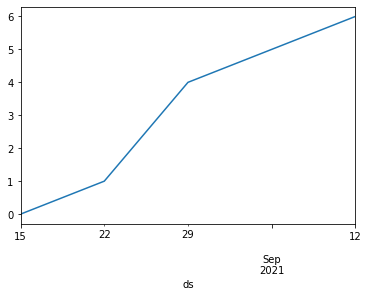

In [29]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()